### Numpy installation

In [ ]:
! pip uninstall numpy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.0.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e71.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? 

In [ ]:
! pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
print(np.__version__)

1.26.4


If for some reason it's not equal to 1.26.4, please restart the notebook. It's important to run the catboost classification.

It seems that current version of catboost is not compatible with numpy 2.x.

### Dataset creation

Probably the most important and interesting part of this task: where to find data?

There are datasets like GYAFC, but this one's not publicly available. During my research, I've managed to locate the link to the SQUINKY! dataset. Not sure if it's public or not, but [here](https://people.rc.rit.edu/bsm9339/corpora/squinky_corpus/mturk_merged.csv) it is. Cheers to [this](https://github.com/meyersbs/squinky) guy for leaving links in the repository.

We're interested in column 'formality' that estimates the formality of a sentence on a scale from 1 to 7. Since we solve a classification task, a threshold selection for this dataset will be chosen later on. This threshold would allow us to separate two classes.

The dataset is quite old, so I've got an idea to use modern LLM's to help me acquire data. I've asked ChatGPT to generate me a diverse set of 250 strictly formal, 250 very informal phrases. I've also asked it to generate 250 sentences that are somewhere in the middle. I've asked GPT to tell if those are more formal or informal.

So, this would be my data. A few ideas that could've been implemented: fan fiction books tend to be very informal, so sentences from these might be useful. Some SMS/messengers data might be useful as well (if it's legal).



In [ ]:
! pip install pip-system-certs

In [ ]:
import pandas as pd
import ssl

ssl._create_default_https_context = ssl._create_unverified_context # some stuff to pass ssl certificate errors

url = "https://people.rc.rit.edu/bsm9339/corpora/squinky_corpus/mturk_merged.csv"
squinky_data = pd.read_csv(url)

In [ ]:
squinky_data

,id,formality,informativeness,implicature,sentence
0,0,6.0,6.1,3.8,10In High Bay 4 of the Vehicle Assembly Buildi...
1,1,5.6,6.1,3.3,12The oxygen vent arm and hood removed from th...
2,2,5.5,6.0,4.2,"13In the Rotation, Processing and Surge Facili..."
3,3,5.0,5.1,3.3,14In the Vehicle Assembly Building's High Bay ...
4,4,5.1,5.0,3.0,15In the Vehicle Assembly Building's High Bay ...
...,...,...,...,...,...
7027,7031,2.6,2.2,4.4,Let's hope it's true.
7028,7032,1.7,2.1,4.8,"Cheer up, Sony (NYSE: SNE) fans."
7029,7033,4.9,5.4,3.7,Wired is one of the few publications that acts...
7030,7034,5.5,5.9,3.7,"As NewsBusters reported Friday, conservative t..."


In [ ]:
squinky_data = squinky_data[['formality', 'sentence']]
squinky_data

,formality,sentence
0,6.0,10In High Bay 4 of the Vehicle Assembly Buildi...
1,5.6,12The oxygen vent arm and hood removed from th...
2,5.5,"13In the Rotation, Processing and Surge Facili..."
3,5.0,14In the Vehicle Assembly Building's High Bay ...
4,5.1,15In the Vehicle Assembly Building's High Bay ...
...,...,...
7027,2.6,Let's hope it's true.
7028,1.7,"Cheer up, Sony (NYSE: SNE) fans."
7029,4.9,Wired is one of the few publications that acts...
7030,5.5,"As NewsBusters reported Friday, conservative t..."


### SQUINKY! Threshold

To find out the threshold for the dataset that would allow us to separate it, let's take a look at the data.

(array([  5.,  16.,  41.,  91., 147., 157., 245., 130., 298., 337., 354.,
        347., 351., 340., 196., 386., 395., 387., 413., 423., 465., 437.,
        217., 341., 250., 149.,  73.,  32.,   6.,   3.]),
 array([1.        , 1.18666667, 1.37333333, 1.56      , 1.74666667,
        1.93333333, 2.12      , 2.30666667, 2.49333333, 2.68      ,
        2.86666667, 3.05333333, 3.24      , 3.42666667, 3.61333333,
        3.8       , 3.98666667, 4.17333333, 4.36      , 4.54666667,
        4.73333333, 4.92      , 5.10666667, 5.29333333, 5.48      ,
        5.66666667, 5.85333333, 6.04      , 6.22666667, 6.41333333,
        6.6       ]),
 <BarContainer object of 30 artists>)

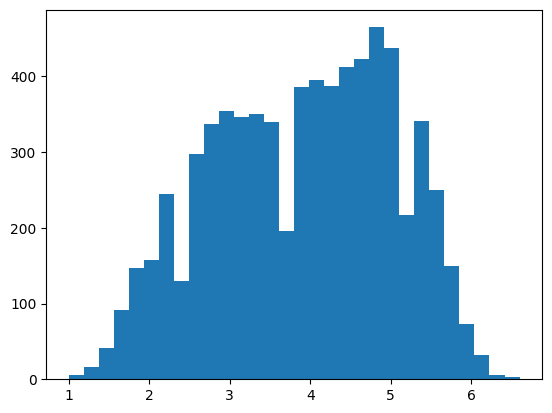

In [ ]:
import matplotlib.pyplot as plt

plt.hist(squinky_data['formality'], bins = 30)

In [ ]:
squinky_data['formality'].median()

4.0

In [ ]:
squinky_data['formality'].mean()

3.9116894197952217

Meaning roughly a half of the dataset is above the threshold of 4. Since we are to evaluate the models, I'll manually set the threshold after comparing the data samples where the formality is equal to 4.0 and is a bit higher or lower.

In [ ]:
squinky_data[squinky_data['formality'] == 4.0]['sentence'][:20].to_list()

['2Ares I First Stage Motor Unveiled on July 20, 2009.',
 '3) check on the "Network Printer" radio button and choose Unix Printer (LPD) and enter the IP address of your print server (for your case, it might be 192.168.0.1) for the "host" and lp for the Queue , then click "forward"',
 '4. In the "host:" box, type the IP address of the print server.',
 "After finishing 2-11 last season in Wulff's first year, the Cougars have four games left against Arizona, UCLA, Oregon State and Washington.",
 'A lot of damage was caused by this crisis.',
 'A lot of politicians and political operatives in DC are very impressed by polling that shows people concerned about the budget deficit.',
 'And at the risk of maybe sounding undiplomatic, Pakistan has to have more internal investment in your public services and in your business opportunities.',
 'And, of course, he uses social media to connect as much as possible:',
 'And printing a PDF-file straight to the printer with "lp file.pdf" puts the printer

In [ ]:
squinky_data[squinky_data['formality'] == 4.3].head()['sentence'].to_list()

['Above all, the web is shifting, from static pages to social media, from search to discovery, and the long-term leadership of that new web is still up for grabs.',
 'Activists dump tonnes of coal in Vattenfall protest (28 Oct 09)',
 'A few hours from now, tens of thousands of runners will hit New York streets.',
 'All it needed was a spark - the elements were already there.',
 'Also up for grabs is a House seat from the 9th District, which includes Pullman and Cheney.']

In [ ]:
squinky_data[squinky_data['formality'] == 3.7].head()['sentence'].to_list()

['1. Go to System/Administration/Printing 2.',
 '4. Click Forward.',
 '4)from here on, you should be able to carry on, choose the correct printer driver and do a test page after installing.',
 "After last week's fiasco, when an eastern span patch job fell apart after a mere seven weeks - we certainly hope so.",
 'Also to get to the restaurants, shops and even the lobby of the hotel, it is a smoking property, so there will be people smoking in public.']

As expected, sentences with formality of 4.0 are on the border. I'll set the threshold to 4.0. All the sentences with a formality score above it will be considered formal (class = 0), those that have lower or equla score — informal (class = 1).

In [ ]:
squinky_data['class'] =[0 if x > 4.0 else 1 for x in squinky_data['formality']]

<ipython-input-12-5b90e85a17ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  squinky_data['class'] =[0 if x > 4.0 else 1 for x in squinky_data['formality']]


In [ ]:
squinky_data = squinky_data.drop('formality', axis=1)

In [ ]:
squinky_data

,sentence,class
0,10In High Bay 4 of the Vehicle Assembly Buildi...,0
1,12The oxygen vent arm and hood removed from th...,0
2,"13In the Rotation, Processing and Surge Facili...",0
3,14In the Vehicle Assembly Building's High Bay ...,0
4,15In the Vehicle Assembly Building's High Bay ...,0
...,...,...
7027,Let's hope it's true.,1
7028,"Cheer up, Sony (NYSE: SNE) fans.",1
7029,Wired is one of the few publications that acts...,0
7030,"As NewsBusters reported Friday, conservative t...",0


### ChatGPT response data

In [ ]:
! pip install striprtf

In [ ]:
from striprtf.striprtf import rtf_to_text

filenames = ['formal_sentences.rtf', 'informal_sentences.rtf', 'middle_sentences.rtf']

formal_sentences = []
informal_sentences = []

for filename in filenames:
    with open(filename, 'r', encoding='utf-8') as file:
        rtf_content = file.read()

        plain_text = rtf_to_text(rtf_content)

        plain_text = plain_text.split('\n')

        sentences = [x for x in plain_text if x != '']

        if filename == 'formal_sentences.rtf':
            formal_sentences = sentences
        elif filename == 'informal_sentences.rtf':
            informal_sentences = sentences
        elif filename == 'middle_sentences.rtf':
            for sentence in sentences:
              class_ = int(sentence[-2:])
              if class_ == 0:
                formal_sentences.append(sentence[:-2])
              else:
                informal_sentences.append(sentence[:-2])

In [ ]:
formal_sentences[16]

'Your insights and advice have been incredibly beneficial.'

In [ ]:
informal_sentences[16]

'Thanks a bunch, my friend!'

### Merge data

In [ ]:
gpt_data = [formal_sentences + informal_sentences, [0] * len(formal_sentences) + [1] * len(informal_sentences)]

In [ ]:
gpt_data = pd.DataFrame(gpt_data, index=['sentence', 'class']).T

In [ ]:
gpt_data

,sentence,class
0,I extend my sincere gratitude for your invalua...,0
1,Your presence at the event was truly an honor.,0
2,I am profoundly grateful for your unwavering s...,0
3,It was an absolute pleasure to collaborate wit...,0
4,Please accept my deepest appreciation for your...,0
...,...,...
746,You made all the difference—thank you so much!,1
747,Really appreciate how smoothly you handled that!,1
748,Can’t thank you enough for your constant support!,1
749,Thanks for always bringing a positive attitude!,1


In [ ]:
all_data = pd.concat([squinky_data, gpt_data], ignore_index=True)

In [ ]:
all_data

,sentence,class
0,10In High Bay 4 of the Vehicle Assembly Buildi...,0
1,12The oxygen vent arm and hood removed from th...,0
2,"13In the Rotation, Processing and Surge Facili...",0
3,14In the Vehicle Assembly Building's High Bay ...,0
4,15In the Vehicle Assembly Building's High Bay ...,0
...,...,...
7778,You made all the difference—thank you so much!,1
7779,Really appreciate how smoothly you handled that!,1
7780,Can’t thank you enough for your constant support!,1
7781,Thanks for always bringing a positive attitude!,1



### Models

While searching for the existing solutions to this problem, I've found an article ["Detecting Text Formality: A Study of Text Classification Approaches"](https://arxiv.org/abs/2204.08975).

The authors train models for formality detection task in three scenarios: monolingual, multilingual and cross-lingual. In my work I focus on the monolingual task since the collected dataset is in English.

This work proposes state-of-the art approaches to the problem. Here I use two of the models: fine-tuned [mDeBERTa](https://huggingface.co/s-nlp/deberta-large-formality-ranker) and fine-tuned [XLM-Roberta-based](https://huggingface.co/s-nlp/xlmr_formality_classifier) classifier. For all of the models I use the tokenizers from the HuggingFace page example.

We start with mDeBERTa:

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch


model_name = 's-nlp/deberta-large-formality-ranker'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
deberta_tokenizer = AutoTokenizer.from_pretrained(model_name)
deberta = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Example usage: 2 informal, one formal.

In [ ]:
inputs = ["lol bruh im a bit tired rn ", "damn mate", "I enjoy watching my companion attempt to role-play with them."]

In [ ]:
encodings = deberta_tokenizer(inputs, padding=True, truncation=True, max_length=24, return_tensors="pt")

In [ ]:
pred = deberta(**encodings.to(device))

We can just take maximum of the logits to predict the class:

In [ ]:
preds = pred.logits.argmax(-1)

preds

tensor([1, 1, 0], device='cuda:0')

Here label 1 stands for Informal sentence, label 0 for formal.

Then we move to XLM-Roberta-based classifier:

In [ ]:
from transformers import XLMRobertaTokenizerFast, XLMRobertaForSequenceClassification


roberta_tokenizer = XLMRobertaTokenizerFast.from_pretrained('s-nlp/xlmr_formality_classifier')
roberta = XLMRobertaForSequenceClassification.from_pretrained('s-nlp/xlmr_formality_classifier').to(device)

tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/896 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
encodings = roberta_tokenizer(
    inputs,
    add_special_tokens=True,
    return_token_type_ids=True,
    truncation=True,
    padding="max_length",
    return_tensors="pt",
)

In [ ]:
pred = roberta(**encodings.to(device))

In [ ]:
preds = pred.logits.argmax(-1)

preds

tensor([1, 1, 0], device='cuda:0')

### Catboost

I decided to check if other approaches would work too. To do so I use catboost model. I extract some features from the data and train a CatboostClassifier model.

In [ ]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.5 MB/s eta 0:00:00


In [ ]:
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier

We select words that are formality/informality indicators:

In [ ]:
slang_words = {
    "gonna", "wanna", "gotta", "bro", "bruh", "lol", "lmao", "rofl", "yo", "wassup", "lit", "fam", "dude", "nah", "yolo",
    "omg", "idk", "smh", "tbh", "btw", "thx", "pls", "fyi", "imo", "imho", "nope", "yup", "dope", "sick", "chill", "brb",
    "ttyl", "bff", "bae", "hmu", "jk", "np", "srsly", "ngl", "ikr", "cuz", "coz", "sup", "yo", "meh", "okie"
}

signoffs = {
    "regards", "sincerely", "best", "best regards", "kind regards", "warm regards", "respectfully", "cheers", "thanks",
    "thank you", "yours truly", "yours sincerely", "warmest regards", "take care", "all the best", "many thanks",
    "appreciatively", "with appreciation", "gratefully", "later", "see ya", "peace out"
}

polite_words = {
    "please", "kindly", "would you", "could you", "may I", "if you don't mind", "would it be possible", "I'd appreciate it",
    "thank you", "thanks in advance", "pardon me", "excuse me", "would you mind", "it would be great if", "I would be grateful",
    "may I request", "your assistance is appreciated", "if possible"
}

formal_words = {
    "regarding", "therefore", "furthermore", "moreover", "accordingly", "respectfully", "hence", "nevertheless",
    "thus", "notwithstanding", "consequently", "in accordance with", "pursuant to", "aforementioned", "hereinafter",
    "henceforth", "insofar", "nonetheless", "in the event that", "in lieu of", "whereas", "wherein", "inasmuch as",
    "prior to", "subsequently", "to that end", "with reference to"
}

We also want to locate any contractions like 'don't' or 'I'll':

In [ ]:
contraction_pattern = re.compile(r"\b(?:[A-Za-z]+n't|[A-Za-z]+'ll|[A-Za-z]+'ve|[A-Za-z]+'re|[A-Za-z]+'d|[A-Za-z]+'m)\b")

In [ ]:
def extract_features(text):
    words = text.split()
    num_words = len(words) # amount of words
    num_chars = len(text) # amount of symbols
    num_upper = sum(1 for c in text if c.isupper()) # capital letters
    num_exclam = text.count('!') # exclamation mark amount
    num_contractions = len(contraction_pattern.findall(text)) # contraction amount
    num_slang = sum(1 for word in words if word.lower() in slang_words) # amount of slang words
    num_signoffs = sum(1 for word in words if word.lower() in signoffs) # amount of signoffs
    num_polite = sum(1 for word in words if word.lower() in polite_words) # amount of polite words
    num_formal = sum(1 for word in words if word.lower() in formal_words) # amount of formal words
    num_punct = sum(1 for c in text if c in string.punctuation) # number of punctuation chars
    digit_ratio = sum(c.isdigit() for c in text) / (num_chars + 1e-5) # if the text is heavy on digits

    return [
        num_chars,
        np.mean([len(word) for word in words]) if words else 0,
        num_upper,
        num_exclam,
        num_contractions,
        num_slang,
        num_signoffs,
        num_polite,
        num_formal,
        num_punct,
        digit_ratio
    ]

In [ ]:
catboost_data = all_data.copy()

To train CatBoost model we have to add extra features to the text. I decided to use the length of the text, average word length, number of uppercase letters, exclamation marks, contractions, slang words, signoffs, polite and formal word and punctuation. Digit to all the chars ratio may also be helpful.  

In [ ]:
feature_names = [
    "text_length", "avg_word_length", "uppercase_count", "exclamation_count",
    "contraction_count", "slang_count", "signoff_count", "polite_count",
    "formal_count", "punctuation_count", "digit_ratio"
]
catboost_data[feature_names] = catboost_data["sentence"].apply(lambda x: pd.Series(extract_features(x)))

Now we split the data to train and test, so that we can train and evaluate our model.

In [ ]:
X = catboost_data[feature_names]
y = catboost_data["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Training and inference step:

In [ ]:
catboost = CatBoostClassifier(verbose=0)
catboost.fit(X_train, y_train)

In [ ]:
y_pred = catboost.predict(X_test)

It's quite interesting to see which features had the most impact on the result. We can check the feature importance:

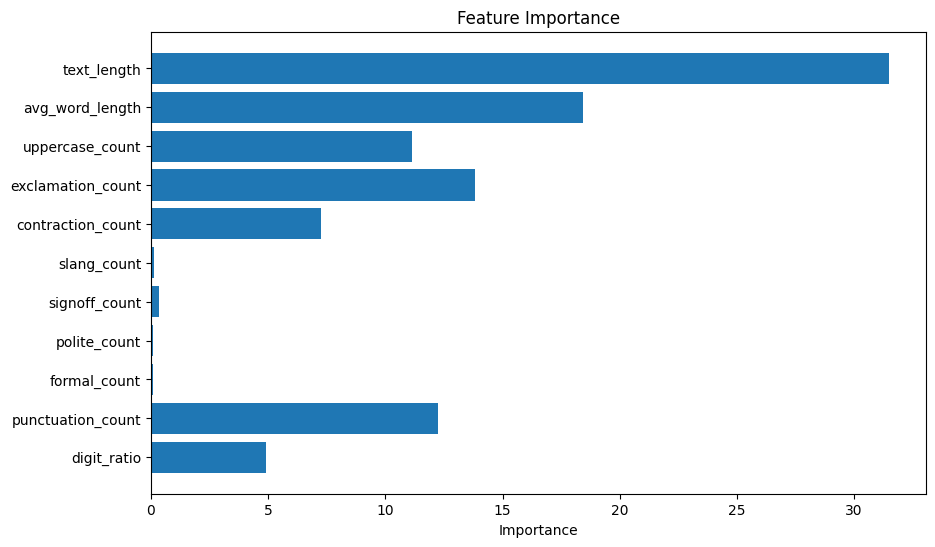

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_names, catboost.feature_importances_)
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

We see that the length and average text length were the most important of all. People tend to use shorter words in informal speech, which explains it.

Exclamation marks and contractions serve as markers of informal speech, while punctuation and digits might help to detect formality. Signoffs slightly help, but overall our lists of words did not help much.

### Metrics




Next step is to choose metrics. Accuracy, precision, recall and F1 are commonly used in these tasks, which was seen in the related articles. I'll stick to those.

In [ ]:
input_data = all_data['sentence'].to_list()
labels = all_data['class'].to_list()


listed_data = list(zip(input_data, labels))

In [ ]:
from torch.utils.data import DataLoader

val_loader = DataLoader(listed_data, shuffle=False, batch_size = 50)

In [ ]:
from tqdm import tqdm

def evaluate_model(model, tokenizer, val_loader, device=torch.device('cpu')):
  num_batches = len(val_loader)

  prediction = []
  all_labels = []

  for i in tqdm(range(num_batches)):
    sentences, labels = next(iter(val_loader))
    encodings = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors="pt")

    with torch.no_grad():
      logits = model(**encodings.to(device)).logits

    prediction += logits.argmax(-1).cpu()
    all_labels += labels.cpu()

  print(classification_report(all_labels, prediction, target_names=['formal', 'informal']))

In [ ]:
evaluate_model(deberta, deberta_tokenizer,  val_loader, device)

100%|██████████| 156/156 [00:39<00:00,  3.94it/s]

              precision    recall  f1-score   support

      formal       0.80      0.77      0.78      4056
    informal       0.76      0.79      0.78      3744

    accuracy                           0.78      7800
   macro avg       0.78      0.78      0.78      7800
weighted avg       0.78      0.78      0.78      7800



In [ ]:
evaluate_model(roberta, roberta_tokenizer, val_loader, device)

100%|██████████| 156/156 [00:10<00:00, 15.07it/s]


              precision    recall  f1-score   support

      formal       0.76      0.50      0.60      4056
    informal       0.61      0.83      0.70      3744

    accuracy                           0.66      7800
   macro avg       0.69      0.67      0.65      7800
weighted avg       0.69      0.66      0.65      7800



And now metrics for CatboostClassifier. Here I test the model on test dataset, which is only 20% from the `all_data`. It was required because the classifier had to be trained.

In [ ]:
print(classification_report(y_test.to_list(), y_pred, target_names=['formal', 'informal']))

              precision    recall  f1-score   support

      formal       0.82      0.83      0.83       777
    informal       0.83      0.82      0.83       780

    accuracy                           0.83      1557
   macro avg       0.83      0.83      0.83      1557
weighted avg       0.83      0.83      0.83      1557



### Conclusions

As a result of my work, I can say that finr-tuned Deberta beats fine-tuned Roberta by a margin of 0.12 in terms of accuracy. It performed better in precision, recall and F1 as well.

To my surprise, CatboostClassifier managed to beat both of them. I believe that it happened because it was trained on the samples from our dataset. Our choice of the threshold may have affected the quality of the result.